In [7]:
import os
import cv2
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from skimage.feature import hog, local_binary_pattern
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [8]:
def plot_tsne(X, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X)

    # Create a colormap for distinct colors based on the labels
    unique_labels = np.unique(labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    label_cmap = ListedColormap(colors)

    plt.figure(figsize=(8, 8))
    for i, label in enumerate(unique_labels):
        indices = labels == label
        plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], label=f'Label {label}', cmap=label_cmap)

    plt.title(title)
    plt.legend()
    plt.show()

# Apply filters and plot t-SNE for each combination
# filter_types = ['entropy','canny', 'sobel','hog',"gabor"]
# kernel_types = []
# kernel_types = []

# train_csv = pd.read_csv('/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/Training_set.csv')
# test_csv = pd.read_csv('/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/Testing_set.csv')
# train_path='/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/train/'
# test_path='/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/'

train_csv = pd.read_csv('./Training_set.csv')
# test_csv = pd.read_csv('./Testing_set.csv')
train_path='./train/'
# test_path='./test/'

In [9]:


def extract_color_histogram(image_path, bins=(8, 8, 8)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (128, 128))
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()
    return [0]

def extract_lbp_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128))
    lbp = local_binary_pattern(image, P=8, R=1, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 10))
    return hist
    return [0]

def extract_sift_features(image_path,max_keypoints=100):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (128, 128))
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if len(keypoints) > max_keypoints:
        keypoints = sorted(keypoints, key=lambda x: x.response, reverse=True)[:max_keypoints]
        descriptors = sift.compute(image, keypoints)[1]

    # Flatten and normalize descriptors to ensure a consistent feature vector size
    sift_features = descriptors.flatten()
    if len(sift_features) < max_keypoints * 128:
        sift_features = np.concatenate([sift_features, np.zeros(max_keypoints * 128 - len(sift_features))])

    return sift_features.flatten() 
    return [0]

def data():
    Y = train_csv['label']
    le = LabelEncoder()
    y = le.fit_transform(Y)
    pickle.dump(le, open('label_encoder.pkl', 'wb'))

    
    X_list = []

    for i in range(0, train_csv.shape[0]):
        img_path = train_path + train_csv['filename'][i]
        
        # Extract HOG features
        img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (128, 128))
        im2 = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
#         im2=[0]
        # Extract color histogram features
        color_hist = extract_color_histogram(img_path)
        
        # Extract LBP features
        lbp_features = extract_lbp_features(img_path)
        
        # Extract SIFT features
        sift_features = extract_sift_features(img_path)
        
        # Combine features horizontally
        combined_features = np.hstack((im2, color_hist, lbp_features, sift_features))
        
        X_list.append(combined_features)
        
        if i % 1000 == 0:
            print(i, combined_features.shape,len(img),len(im2),len(lbp_features),len(sift_features))
    
    X = pd.DataFrame(X_list)
    return X, y

# Example usage:
# X, y = data()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
# Extract features from all images
features,labels = data()
scaler=StandardScaler()
features=scaler.fit_transform(features)
#pickle the scaler
pickle.dump(scaler, open('scaler.pkl', 'wb'))

0 (21421,) 128 8100 9 12800
1000 (21421,) 128 8100 9 12800
2000 (21421,) 128 8100 9 12800
3000 (21421,) 128 8100 9 12800
4000 (21421,) 128 8100 9 12800
5000 (21421,) 128 8100 9 12800
6000 (21421,) 128 8100 9 12800
7000 (21421,) 128 8100 9 12800
8000 (21421,) 128 8100 9 12800
9000 (21421,) 128 8100 9 12800
10000 (21421,) 128 8100 9 12800
11000 (21421,) 128 8100 9 12800
12000 (21421,) 128 8100 9 12800


In [11]:
pca=PCA(n_components=0.95)
features=pca.fit_transform(features)
print(features.shape)
#pickle the pca
pickle.dump(pca, open('pca.pkl', 'wb'))

[2.55558645e-02 1.47532486e-02 6.92269131e-03 ... 4.29997419e-05
 4.29961731e-05 4.29940997e-05]


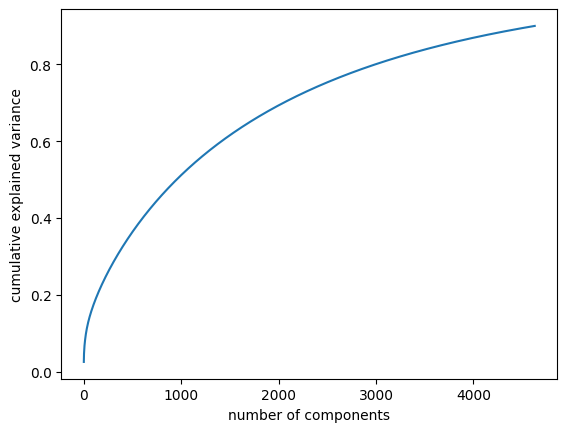

In [ ]:
print(pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

/tmp/ipykernel_19/674177603.py:73: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], label=f'Label {label}', cmap=label_cmap)


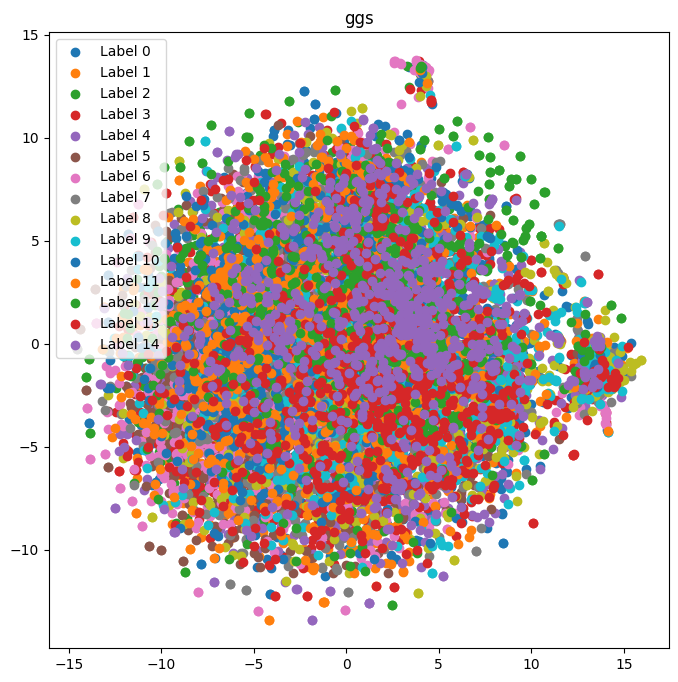

In [ ]:
plot_tsne(features,labels, "t-SNE plot of features")

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [ ]:
# Train an SVM classifier
clf = SVC(kernel='rbf',C=3,gamma="scale")
clf.fit(X_train, y_train)

# Make predictions on the test set
predictions = clf.predict(X_train)
accuracy = accuracy_score(y_train, predictions)
print(f"training Accuracy: {accuracy}")
predictions = clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"test Accuracy: {accuracy}")

pickle.dump(clf, open('model.pkl', 'wb'))

training Accuracy: 1.0
test Accuracy: 0.34325396825396826
